## Classification tasks
BBBP/BACE/ClinTox/Tox21/HIV

In [3]:
# BBBP, BACE, HIV, Tox21_NR-AR, Tox21_NR-AR-LBD, Tox21_NR-AhR
clustered_roc_auc = [0.9010, 0.8599, 0.798, 0.7382, 0.9067, 0.8921]
generated_roc_auc = [0.933, 0.9231, 0.7384, 0.7879, 0.9124, 0.8861]
random_roc_auc = [0.8912, 0.8761, 0.7825, 0.799, 0.8868, 0.9008]

In [4]:
import pandas as pd
results = pd.DataFrame({"clustered":clustered_roc_auc, "generated": generated_roc_auc, "random": random_roc_auc}, 
                       index=['BBBP', 'BACE', 'HIV', 'Tox21_NR-AR', 'Tox21_NR-AR-LBD', 'Tox21_NR-AhR'])

<AxesSubplot:xlabel='Task', ylabel='ROC-AUC'>

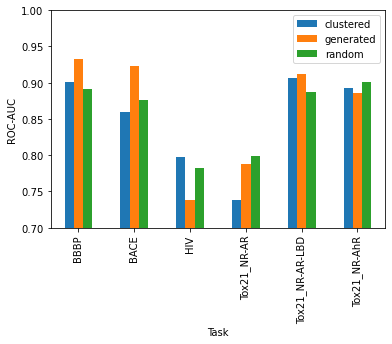

In [15]:
results.plot(y=["clustered", "generated", "random"], kind="bar", ylim=(0.7,1), xlabel='Task', ylabel="ROC-AUC")

## Regression tasks
FreeSolv/ESOL

In [5]:
# Freesolv, Esol
clustered_rmse = [1.5082, 0.984]
generated_rmse = [1.332, 0.903]
random_rmse = [2.777, 1.203]
clustered_gcn = 2.3149


results = pd.DataFrame({"clustered":clustered_rmse, "generated": generated_rmse, "random": random_rmse}, 
                       index=['FreeSolv', 'ESOL'])

<AxesSubplot:xlabel='Task', ylabel='RMSE'>

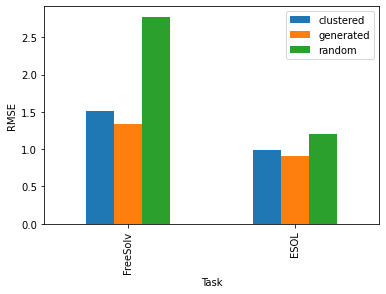

In [8]:
results.plot(y=["clustered", "generated", "random"], kind="bar", xlabel='Task', ylabel="RMSE")

## Representation Plots

In [83]:
from models.gin import GINet
import yaml
import os
import torch

config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)
model = GINet(**config["model"])

model.load_state_dict(torch.load("ckpt/Apr20_10-49-42_esol/checkpoints/model.pth"))
model.eval()

GINet(
  (x_embedding1): Embedding(119, 300)
  (x_embedding2): Embedding(3, 300)
  (gnns): ModuleList(
    (0): GINEConv()
    (1): GINEConv()
    (2): GINEConv()
    (3): GINEConv()
    (4): GINEConv()
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (feat_lin): Linear(in_features=300, out_features=512, bias=True)
  (out_lin): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
)

In [84]:
from dataset.dataset import PairedDataset
dataset = PairedDataset(data_path='data/esol/esol.csv')

SMILES Dictionary Acquired Successfully
Paired Input Indices Produced Successfully


In [128]:
x1s, x2s = dataset[4]
x3s, x4s = dataset[100]
x5s, x6s = dataset[200]
_, z1s = model(x1s)
_, z2s = model(x2s)
_, z3s = model(x3s)
_, z4s = model(x4s)
_, z5s = model(x5s)
_, z6s = model(x6s)

In [90]:
zs = []
for xis, xjs in dataset:
    _, zis = model(xis)
    _, zjs = model(xjs)
    zs += [zis, zjs]

In [96]:
representations = torch.cat(zs).detach().numpy()

In [89]:
# from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(z1s.detach().numpy(), z2s.detach().numpy())
# cosine_similarity(z1s.detach().numpy(), z3s.detach().numpy())

array([[0.98488617]], dtype=float32)

In [107]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
pca.fit(representations)

PCA(n_components=2)

In [129]:
z1s_2d = pca.transform(z1s.detach().numpy())
z2s_2d = pca.transform(z2s.detach().numpy())
z3s_2d = pca.transform(z3s.detach().numpy())
z4s_2d = pca.transform(z4s.detach().numpy())
z5s_2d = pca.transform(z5s.detach().numpy())
z6s_2d = pca.transform(z6s.detach().numpy())

In [130]:
zs_2d = np.stack([z1s_2d, z2s_2d, z3s_2d, z4s_2d, z5s_2d, z6s_2d]).reshape(6,2)
zs_x, zs_y = zs_2d[:,0], zs_2d[:,1]

Text(0, 0.5, 'PCA Dimension 2')

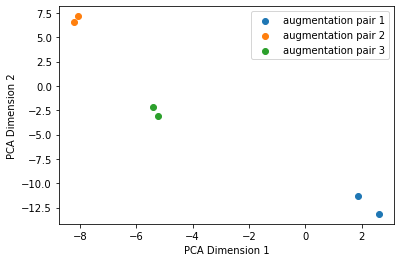

In [131]:
import matplotlib.pyplot as plt 

plt.scatter(zs_2d[:2,0], zs_2d[:2,1], label="augmentation pair 1")
plt.scatter(zs_2d[2:4,0], zs_2d[2:4,1], label="augmentation pair 2")
plt.scatter(zs_2d[4:,0], zs_2d[4:,1], label="augmentation pair 3")
plt.legend()
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

In [122]:
zs_2d[:2,0]

array([2.6023524, 1.8575816], dtype=float32)

In [117]:
all_x, all_y = pca.transform(representations)[:,0], pca.transform(representations)[:,1]

Text(0, 0.5, 'PCA Dimension 2')

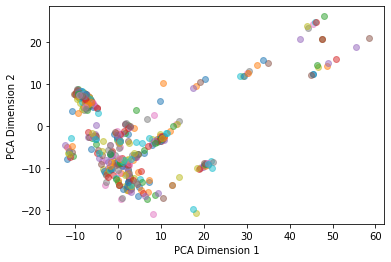

In [135]:
for i in range(len(all_x)):
    plt.scatter(all_x[i], all_y[i], alpha=0.5)
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

In [14]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'RMSE')

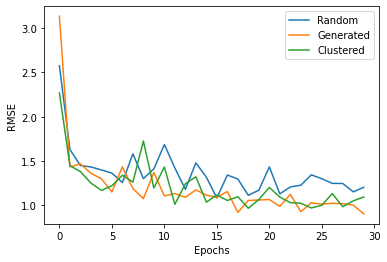

In [16]:
random = pd.read_csv("experiments/run-Apr19_13-58-07_ESOL_measured log solubility in mols per litre_random-tag-validation_rmse.csv")
generated = pd.read_csv("experiments/run-Apr19_14-16-37_ESOL_measured log solubility in mols per litre_generated-tag-validation_rmse.csv")
clustered = pd.read_csv("experiments/run-Apr20_20-09-08_ESOL_measured log solubility in mols per litre_clustered-tag-validation_rmse.csv")

plt.plot(random['Step'], random['Value'], label="Random")
plt.plot(generated['Step'], generated['Value'], label="Generated" )
plt.plot(clustered['Step'], clustered['Value'], label="Clustered")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")

Text(0, 0.5, 'ROC AUC')

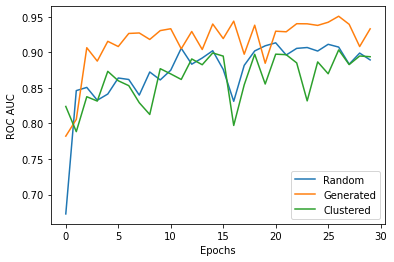

In [17]:
random = pd.read_csv("experiments/run-Apr21_15-30-11_BBBP_p_np_random-tag-validation_roc_auc.csv")
generated = pd.read_csv("experiments/run-Apr21_15-55-11_BBBP_p_np_generated-tag-validation_roc_auc.csv")
clustered = pd.read_csv("experiments/run-Apr21_20-22-57_BBBP_p_np_clustered-tag-validation_roc_auc.csv")

plt.plot(random['Step'], random['Value'], label="Random")
plt.plot(generated['Step'], generated['Value'], label="Generated" )
plt.plot(clustered['Step'], clustered['Value'], label="Clustered")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ROC AUC")

In [19]:
tox21 = pd.read_csv("data/tox21/tox21.csv")

In [27]:
tox21['NR-AhR'].dropna()

0       1.0
1       0.0
3       0.0
4       0.0
5       0.0
       ... 
7824    0.0
7825    0.0
7827    0.0
7828    0.0
7829    0.0
Name: NR-AhR, Length: 6549, dtype: float64

In [31]:
sum(tox21['NR-AR-LBD'].dropna())

237.0

In [30]:
768/7265

0.105712319339298

In [26]:
tox21

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [32]:
bace_gcn = pd.read_csv("experiments/run-Apr21_23-59-19_BACE_Class_clustered_gcn-tag-validation_roc_auc.csv")
bace_gin = pd.read_csv("experiments/run-Apr21_21-01-48_BACE_Class_clustered-tag-validation_roc_auc.csv")

freesolv_gcn = pd.read_csv("experiments/run-Apr21_23-41-52_FreeSolv_expt_clustered_gcn-tag-validation_rmse.csv")
freesolv_gin = pd.read_csv("experiments/run-Apr21_22-26-17_FreeSolv_expt_clustered-tag-validation_rmse.csv")

Text(0, 0.5, 'ROC AUC')

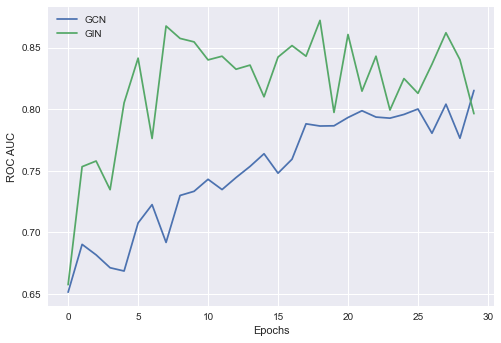

In [45]:
plt.plot(bace_gcn['Step'], bace_gcn['Value'], label="GCN")
plt.plot(bace_gin['Step'], bace_gin['Value'], label="GIN")
plt.style.use('seaborn')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("ROC AUC")

Text(0, 0.5, 'RMSE')

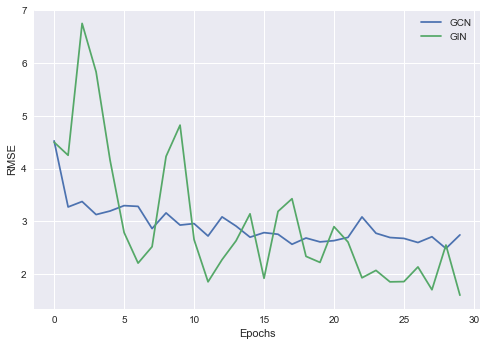

In [46]:
plt.plot(freesolv_gcn['Step'], freesolv_gcn['Value'], label="GCN")
plt.plot(freesolv_gin['Step'], freesolv_gin['Value'], label="GIN")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")